In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import os
import itertools

import typing

import tqdm
import numpy
import joblib
import gtda.images
import torchvision
import skimage.color

import cvtda.utils
import cvtda.topology

def make_image(image, channel: int) -> numpy.ndarray:
    image = numpy.array(image)
    match channel:
        case 'red':
            image = image[:, :, 0]
        case 'green':
            image = image[:, :, 1]
        case 'blue':
            image = image[:, :, 2]
        case 'gray':
            image = skimage.color.rgb2gray(image)
        case _:
            raise NotImplementedError
    assert image.shape == (32, 32)
    return image

def make_diagrams(
    channel: int,
    binarizer,
    filtration,
    n_jobs: int = 1
) -> typing.Tuple[numpy.ndarray, numpy.ndarray]:
    dir = f"1/{channel}/{str(filtration or 'None')}"
    if os.path.exists(f"{dir}/test_features.npy"):
        return 1, 2
    os.makedirs(dir, exist_ok = True)
    
    with joblib.parallel_backend("loky", inner_max_num_threads = n_jobs):
        train = numpy.array(
            joblib.Parallel(n_jobs = n_jobs)(
                joblib.delayed(make_image)(item[0], channel)
                for item in torchvision.datasets.CIFAR100('cifar-100', train = True, download = False)
            )
        )
        test = numpy.array(
            joblib.Parallel(n_jobs = n_jobs)(
                joblib.delayed(make_image)(item[0], channel)
                for item in torchvision.datasets.CIFAR100('cifar-100', train = False, download = False)
            )
        )

        if binarizer is not None:
            train = binarizer.fit_transform(train)
            test = binarizer.transform(test)
            
        if filtration is not None:
            train = filtration.fit_transform(train)
            test = filtration.transform(test)
        
        filtrations_to_diagrams = cvtda.topology.FiltrationsToDiagrams(verbose = False, n_jobs = n_jobs)
        train = filtrations_to_diagrams.fit_transform(train)
        test = filtrations_to_diagrams.transform(test)

    numpy.save(f"{dir}/train_diagrams.npy", train)
    numpy.save(f"{dir}/test_diagrams.npy", test)
    
    if len(train[0]) < 96:
        n_bins = 32
    elif len(train[0]) < 192:
        n_bins = 64
    else:
        n_bins = 128

    with joblib.parallel_backend("loky", inner_max_num_threads = n_jobs):
        digrams_to_features = cvtda.topology.DiagramsToFeatures(batch_size = 500, n_bins = n_bins, verbose = False, n_jobs = n_jobs)
        train = digrams_to_features.fit_transform(train)
        test = digrams_to_features.transform(test)

    numpy.save(f"{dir}/train_features.npy", train)
    numpy.save(f"{dir}/test_features.npy", test)

    return train, test

def process(channel: int, binarizer_threshold: float) -> typing.Tuple[numpy.ndarray, numpy.ndarray]:
    centers = [ 5, 12, 18, 25 ]
    greyscale_to_filtrations = cvtda.topology.GreyscaleToFiltrations(
        n_jobs = 2,
        radial_filtration_centers = list(itertools.product(centers, centers))
    )
    diagrams = joblib.Parallel(return_as = 'generator', n_jobs = 8)(
        joblib.delayed(make_diagrams)(
            channel,
            binarizer = gtda.images.Binarizer(threshold = binarizer_threshold, n_jobs = 1),
            filtration = filtration,
            n_jobs = 2
        )
        for filtration in greyscale_to_filtrations.filtrations_
    )
    for train, test in tqdm.tqdm(diagrams, total = len(greyscale_to_filtrations.filtrations_)):
        pass

    make_diagrams(
        channel,
        binarizer = None,
        filtration = None,
        n_jobs = -1
    )

In [19]:
for channel in [ 'red', 'green', 'blue' ]:
    print(f'>>> Calculating channel {channel}')
    process(channel, 0.4)

>>> Calculating channel red


100%|██████████| 10000/10000 [00:01<00:00, 6939.62it/s]
d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>>> Calculating channel green


100%|██████████| 10000/10000 [00:01<00:00, 7017.54it/s]
d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>>> Calculating channel blue


100%|██████████| 10000/10000 [00:01<00:00, 6485.08it/s]
d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [23]:
train_features = [ ]
test_features = [ ]
for filtration in tqdm.tqdm(os.listdir(f"1/red")):
    for channel in [ 'red', "green", "blue" ]:
        train_features.append(numpy.load(f"1/{channel}/{filtration}/train_features.npy"))
        test_features.append(numpy.load(f"1/{channel}/{filtration}/test_features.npy"))

train_features = numpy.hstack(train_features)
test_features = numpy.hstack(test_features)

train_features.shape, test_features.shape

100%|██████████| 25/25 [00:00<00:00, 26.57it/s]


((50000, 5250), (10000, 5250))

In [3]:
import numpy
import torchvision
import torchvision.transforms.v2

train = torchvision.datasets.CIFAR100('cifar-100', train = True, download = False)
test = torchvision.datasets.CIFAR100('cifar-100', train = False, download = False)

train_labels = numpy.array([ item[1] for item in train ])
test_labels = numpy.array([ item[1] for item in test ])

train_labels.shape, test_labels.shape

((50000,), (10000,))

In [4]:
superclasses = [['beaver', 'dolphin', 'otter', 'seal', 'whale'],
              ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
              ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
              ['bottle', 'bowl', 'can', 'cup', 'plate'],
              ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
              ['clock', 'keyboard', 'lamp', 'telephone', 'television'],
              ['bed', 'chair', 'couch', 'table', 'wardrobe'],
              ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
              ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
              ['bridge', 'castle', 'house', 'road', 'skyscraper'],
              ['cloud', 'forest', 'mountain', 'plain', 'sea'],
              ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
              ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
              ['crab', 'lobster', 'snail', 'spider', 'worm'],
              ['baby', 'boy', 'girl', 'man', 'woman'],
              ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
              ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
              ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
              ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
              ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']]

mapping = {}
for class_name in train.classes:
    for i, superclass in enumerate(superclasses):
        if class_name in superclass:
            mapping[train.class_to_idx[class_name]] = i

for i in range(len(train_labels)):
    train_labels[i] = mapping[train_labels[i]]

for i in range(len(test_labels)):
    test_labels[i] = mapping[test_labels[i]]

print(train_labels.shape, test_labels.shape)
numpy.unique(train_labels), numpy.unique(test_labels)

(50000,) (10000,)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]))

In [27]:
import sklearn.preprocessing

selected_standard_scaler = sklearn.preprocessing.StandardScaler()
train_features = selected_standard_scaler.fit_transform(train_features)
test_features = selected_standard_scaler.transform(test_features)

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
{'classifier': 'KNeighborsClassifier', 'Accuracy': 0.192, 'TOP-2 Accuracy': 0.3073, 'TOP-3 Accuracy': 0.3945, 'TOP-4 Accuracy': 0.4673, 'TOP-5 Accuracy': 0.5297, 'TOP-6 Accuracy': 0.5842, 'TOP-7 Accuracy': 0.637, 'TOP-8 Accuracy': 0.6826, 'TOP-9 Accuracy': 0.7233, 'AUC-ROC': 0.713811657894737, 'Precision': 0.19029211043232036, 'Recall': 0.192, 'F1-score': 0.18391271137382617}
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
{'classifier': 'RandomForestClassifier', 'Accuracy': 0.2849, 'TOP-2 Accuracy': 0.4183, 'TOP-3 Accuracy': 0.5076, 'TOP-4 Accuracy': 0.5805, 'TOP-5 Accuracy': 0.6367, 'TOP-6 Accuracy': 0.6897, 'TOP-7 Accuracy': 0.7348, 'TOP-8 Accuracy': 0.7739, 'TOP-9 Accuracy': 0.8062, 'AUC-ROC': 0.7843592684210525, 'Precision': 0.2796045808916524, 'Recall': 0.28490000000000004, 'F1-score': 0.27589881047268416}
Fitting <cvtda.classification.nn_classifier.NNClassifier object at 0x00000205CEA63550>
Input to LazyLinear: 5

100%|██████████| 25/25 [01:06<00:00,  2.67s/it, loss=1.41e+5, val_acc=0.272]


{'classifier': 'NNClassifier', 'Accuracy': 0.2718, 'TOP-2 Accuracy': 0.3853, 'TOP-3 Accuracy': 0.4553, 'TOP-4 Accuracy': 0.5109, 'TOP-5 Accuracy': 0.5647, 'TOP-6 Accuracy': 0.6153, 'TOP-7 Accuracy': 0.6613, 'TOP-8 Accuracy': 0.7013, 'TOP-9 Accuracy': 0.7353, 'AUC-ROC': 0.7524772315789475, 'Precision': 0.1691747327471225, 'Recall': 0.2718, 'F1-score': 0.2027710693274794}
Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
{'classifier': 'HistGradientBoostingClassifier', 'Accuracy': 0.2933, 'TOP-2 Accuracy': 0.4333, 'TOP-3 Accuracy': 0.5287, 'TOP-4 Accuracy': 0.6076, 'TOP-5 Accuracy': 0.6677, 'TOP-6 Accuracy': 0.7177, 'TOP-7 Accuracy': 0.7603, 'TOP-8 Accuracy': 0.8005, 'TOP-9 Accuracy': 0.8326, 'AUC-ROC': 0.8077477157894736, 'Precision': 0.28824752313397184, 'Recall': 0.2933, 'F1-score': 0.28539296442736545}
Fitting <catboost.core.CatBoostClassifier object at 0x00000205CEA62EF0>
Learning rate set to 0.309284
0

d:\Programs\Programming\Python\lib\site-packages\xgboost\core.py:158: UserWarning: [19:25:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


{'classifier': 'XGBClassifier', 'Accuracy': 0.3256, 'TOP-2 Accuracy': 0.4714, 'TOP-3 Accuracy': 0.57, 'TOP-4 Accuracy': 0.6442, 'TOP-5 Accuracy': 0.7039, 'TOP-6 Accuracy': 0.7516, 'TOP-7 Accuracy': 0.793, 'TOP-8 Accuracy': 0.8286, 'TOP-9 Accuracy': 0.8575, 'AUC-ROC': 0.8295552421052632, 'Precision': 0.32071372651987173, 'Recall': 0.3256, 'F1-score': 0.3194492880062405}


,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.1920,0.3073,0.3945,0.4673,0.5297,0.5842,0.6370,0.6826,0.7233,0.713812,0.190292,0.1920,0.183913
1,RandomForestClassifier,0.2849,0.4183,0.5076,0.5805,0.6367,0.6897,0.7348,0.7739,0.8062,0.784359,0.279605,0.2849,0.275899
2,NNClassifier,0.2718,0.3853,0.4553,0.5109,0.5647,0.6153,0.6613,0.7013,0.7353,0.752477,0.169175,0.2718,0.202771
3,HistGradientBoostingClassifier,0.2933,0.4333,0.5287,0.6076,0.6677,0.7177,0.7603,0.8005,0.8326,0.807748,0.288248,0.2933,0.285393
4,CatBoostClassifier,0.3712,0.5186,0.6180,0.6884,0.7427,0.7915,0.8288,0.8597,0.8840,0.855312,0.366200,0.3712,0.366770
5,XGBClassifier,0.3256,0.4714,0.5700,0.6442,0.7039,0.7516,0.7930,0.8286,0.8575,0.829555,0.320714,0.3256,0.319449


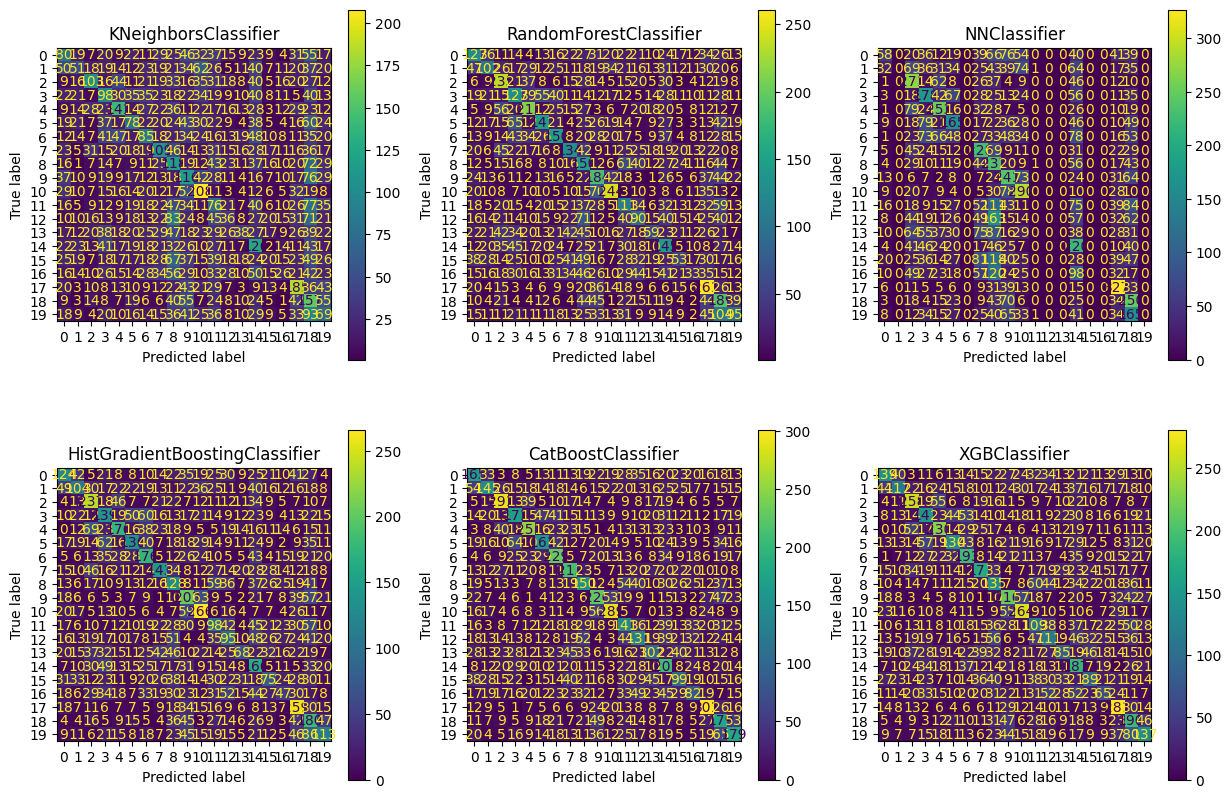

In [43]:
import cvtda.classification

cvtda.classification.classify(train_features, train_labels, test_features, test_labels)

In [6]:
import tqdm
import joblib
import torch
import gtda.diagrams
import torchph.nn.slayer

def process():
    def transform(diagram, dim):
        dim_filter = (diagram[:, 2] == dim)
        non_degenerate_filter = (diagram[:, 0] != diagram[:, 1])
        rotation = torchph.nn.slayer.UpperDiagonalThresholdedLogTransform(0.05)
        return rotation(diagram[dim_filter & non_degenerate_filter][:, 0:2])

    train_data = [ ]
    test_data = [ ]
    for filtration in tqdm.tqdm(os.listdir(f"1/red")):
        for dim in [ 0, 1 ]:
            for channel in [ 'red', "green", "blue" ]:
                dir = f"1/{channel}/{filtration}"
                train_diagrams = numpy.load(f"{dir}/train_diagrams.npy")
                test_diagrams = numpy.load(f"{dir}/test_diagrams.npy")

                scaler = gtda.diagrams.Scaler()
                train_diagrams = scaler.fit_transform(train_diagrams)
                test_diagrams = scaler.transform(test_diagrams)
                
                filtering = gtda.diagrams.Filtering()
                train_diagrams = torch.tensor(filtering.fit_transform(train_diagrams), dtype = torch.float32)
                test_diagrams = torch.tensor(filtering.transform(test_diagrams), dtype = torch.float32)

                diagrams_train = joblib.Parallel(n_jobs = 1)(joblib.delayed(transform)(diagram, dim) for diagram in train_diagrams)
                diagrams, non_dummy_points, _, _ = torchph.nn.slayer.prepare_batch(diagrams_train)
                train_data.append(diagrams)
                train_data.append(non_dummy_points)
                
                diagrams_test = joblib.Parallel(n_jobs = 1)(joblib.delayed(transform)(diagram, dim) for diagram in test_diagrams)
                diagrams, non_dummy_points, _, _ = torchph.nn.slayer.prepare_batch(diagrams_test)
                test_data.append(diagrams)
                test_data.append(non_dummy_points)
    return train_data, test_data

train_diagrams, test_diagrams = process()
 
print(len(train_diagrams), train_diagrams[0].shape, train_diagrams[1].shape)
print(len(test_diagrams), test_diagrams[0].shape, test_diagrams[1].shape)

100%|██████████| 25/25 [21:45<00:00, 52.22s/it]

300 torch.Size([50000, 52, 2]) torch.Size([50000, 52])
300 torch.Size([10000, 34, 2]) torch.Size([10000, 34])


In [12]:
import torch

device = torch.device('cuda')

class SLayerMultiChannel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.n_elements = 128
        self.n_channels = 3
        self.slayers = [
            torchph.nn.slayer.SLayerExponential(self.n_elements).to(device)
            for _ in range(self.n_channels)
        ]
        
    def forward(self, args):
        features = [ ]
        for i in range(0, len(args), 2):
            slayer_args = (args[i].to(device), args[i + 1].to(device), args[i].shape[1], len(args[i]))
            features.append(self.slayers[i // 2](slayer_args))
        return torch.stack(features, dim = 1)
    


class FiltrationBranch(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            SLayerMultiChannel(), torch.nn.BatchNorm1d(3), torch.nn.ReLU(),
            torch.nn.Conv1d(3, 64, kernel_size = 1, stride = 1), torch.nn.BatchNorm1d(64), torch.nn.ReLU(),
            torch.nn.Conv1d(64, 32, kernel_size = 1, stride = 1), torch.nn.BatchNorm1d(32), torch.nn.ReLU(),
            torch.nn.Conv1d(32, 16, kernel_size = 1, stride = 1), torch.nn.BatchNorm1d(16), torch.nn.ReLU(),
            torch.nn.Conv1d(16, 8, kernel_size = 1, stride = 1), torch.nn.BatchNorm1d(8), torch.nn.ReLU(),
            torch.nn.Conv1d(8, 4, kernel_size = 1, stride = 1), torch.nn.BatchNorm1d(4), torch.nn.ReLU(),
            torch.nn.Flatten(), torch.nn.Linear(128 * 4, 128), torch.nn.BatchNorm1d(128), torch.nn.ReLU()
        ).to(device)

        
        self.model = torch.nn.Sequential(
            SLayerMultiChannel(), torch.nn.Flatten()
        ).to(device)
        
    def forward(self, args):
        return self.model(args)


class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.num_branches = 50
        self.branches = [
            FiltrationBranch().to(device)
            for _ in range(self.num_branches)
        ]

        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.4), torch.nn.Linear(self.num_branches * 128 * 3, 256), torch.nn.BatchNorm1d(256), torch.nn.ReLU(),
            torch.nn.Dropout(0.3), torch.nn.Linear(256, 128), torch.nn.BatchNorm1d(128), torch.nn.ReLU(),
            torch.nn.Dropout(0.2), torch.nn.Linear(128, 64), torch.nn.BatchNorm1d(64), torch.nn.ReLU(),
            torch.nn.Dropout(0.1), torch.nn.Linear(64, 32), torch.nn.BatchNorm1d(32), torch.nn.ReLU(),
            torch.nn.Linear(32, 20), torch.nn.Softmax(dim = 1)
        ).to(device)
    
    def forward(self, args):
        features = [ ]
        for i in range(0, len(args), 6):
            features.append(self.branches[i // 6](args[i:i + 6]))
        return self.classifier(torch.cat(features, dim = 1))

In [13]:
import sklearn.metrics
import cvtda.utils
cvtda.utils.set_random_seed(42)

train_dl = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(train_labels, device = device, dtype = torch.long),
        *train_diagrams
    ),
    batch_size = 64,
    shuffle = True
)

test_dl = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(test_labels, device = device, dtype = torch.long),
        *test_diagrams
    ),
    batch_size = 64,
    shuffle = False
)

classifier = Net()

optimizer = torch.optim.AdamW(
    params = classifier.parameters(),
    lr = 1e-3
)

for _ in range(100):
    sum_loss = 0

    classifier.train()
    for (y, *args) in tqdm.tqdm(train_dl):
        optimizer.zero_grad()
        pred = classifier(args)

        loss = torch.nn.functional.cross_entropy(pred, y, reduction = 'sum')
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()
    postfix = { 'loss': sum_loss }

    classifier.eval()
    with torch.no_grad():
        preds = [ ]
        real = [ ]
        for (y, *args) in tqdm.tqdm(test_dl):
            proba = classifier(args)
            preds.extend(torch.argmax(proba, axis = 1).cpu().detach())
            real.extend(y.cpu())

        postfix['val_acc'] = sklearn.metrics.accuracy_score(preds, real)

    print(postfix)

100%|██████████| 157/157 [00:20<00:00,  7.70it/s]


{'loss': 145740.402217865, 'val_acc': 0.2056}


100%|██████████| 157/157 [00:19<00:00,  8.26it/s]


{'loss': 143087.9165878296, 'val_acc': 0.2259}


 25%|██▍       | 194/782 [01:29<04:30,  2.18it/s]


KeyboardInterrupt: 